In [1]:
from langchain_community.tools import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages
from langchain_mistralai import ChatMistralAI
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from uuid import uuid4
from typing import TypedDict,Annotated
from langgraph.types import Interrupt,Command
from langsmith import traceable
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
api_keys=[os.getenv('google'),os.getenv('mistral_ai')]

In [3]:
memory=InMemorySaver()

In [4]:
tool=TavilySearchResults(max_results=2,include_answer=True)
tools=[tool]

/var/folders/kh/4f4bk94j1d36fl9w_7g2nhdm0000gn/T/ipykernel_59105/3676676516.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool=TavilySearchResults(max_results=2,include_answer=True)


In [5]:
google=ChatGoogleGenerativeAI(api_key=api_keys[0],model='gemini-2.5-flash')

In [6]:
llm_with_tool=google.bind_tools(tools=tools)

In [7]:
class LLM_TOOL(TypedDict):
    message: Annotated[list[BaseMessage],add_messages]


In [8]:
graph=StateGraph(LLM_TOOL)

In [9]:
def chatbot(state:LLM_TOOL)->LLM_TOOL['message']:
    messages = state['message']
    if not messages:
        raise ValueError("No messages provided")
    return {'message':[llm_with_tool.invoke(messages)]}


def router(state:LLM_TOOL):
    last_message=state['message'][-1]
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return 'tool'
    return 'end'

In [10]:
tool_node=ToolNode(tools=tools,messages_key='message')

In [11]:
graph.add_node('chatbot',chatbot)
graph.add_node('tool',tool_node)
graph.set_entry_point('chatbot')

graph.add_conditional_edges('chatbot',router,{'tool':'tool','end':END})
graph.add_edge('tool','chatbot')


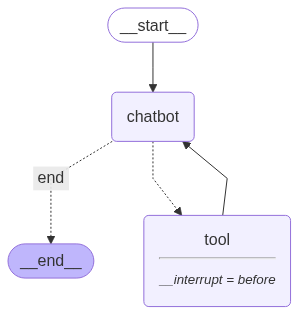

In [12]:
workflow=graph.compile(checkpointer=memory,interrupt_before=['tool'])
workflow

In [13]:
config={
    'configurable':{
        'thread_id':'1'
    }
}

initial={'message':[
    HumanMessage(content='What is the wethear of uk')
]}
events=workflow.stream(
    config=config,input=initial
)



In [15]:
for event in events:
  event['message'][-1].pretty_print()

In [ ]:
events = workflow.stream(None, config, stream_mode="values")
for event in events:
    event["message"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (269f3447-e85b-4ad9-9f5f-0f337af0a5e0)
 Call ID: 269f3447-e85b-4ad9-9f5f-0f337af0a5e0
  Args:
    query: weather in UK
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "19/08/2025 - Mostly dry - Morning Weather Forecast UK", "url": "https://www.youtube.com/watch?v=P2rcUeZ29lE", "content": "19/08/2025 - Mostly dry - Morning Weather Forecast UK – Met Office Weather\nMet Office - UK Weather\n357000 subscribers\n479 likes\n9190 views\n19 Aug 2025\nLow cloud should mostly break up inland, with some lingering along North Sea coasts. A band of thicker cloud with some rain and drizzle with later push from Scotland into northeast England. Cool under the cloud in the east, but warmer in the west. - This is the Met Office UK Weather forecast for the morning of 19/08/2025. Bringing you today’s weather 